In [4]:
%matplotlib inline
import numpy as np
import torch
from matplotlib import pyplot as plt
from tqdm import trange
import pickle
import umap
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [5]:
Xmnist, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

In [6]:
data = Xmnist[0:10000] / 256

In [7]:
colors = [int(x) for x in y[0:10000]]

In [8]:
len(data)

10000

In [9]:
Xref = data

In [128]:
def calc_quality(X, y):
    clf = KNeighborsClassifier(n_neighbors = 5)
    scores = cross_val_score(clf, X, y, cv = 10)
    
    #print(np.mean(scores), np.std(scores)/pow(10, 0.5))
    
    return np.mean(scores)

In [70]:
from cka import cka
import matplotlib.pyplot as plt
import numpy as np

In [165]:
from barcodes import calc_embed_dist, h1sum

def rtd(cl1, cl2):
    return (h1sum(calc_embed_dist(cl1, cl2, pdist_device = 'cpu')) +\
            h1sum(calc_embed_dist(cl2, cl1, pdist_device = 'cpu'))) / 2

In [171]:
def rtd_multi(cl1, cl2, trials = 10, batch = 500):
    rtd_avg = 0
    
    for i in range(trials):
        rnd_idx = list(range(cl1.shape[0]))
        np.random.shuffle(rnd_idx)
        rnd_idx = rnd_idx[:batch]
        rtd_avg += rtd(cl1[rnd_idx], cl2[rnd_idx])
        
    return rtd_avg / trials

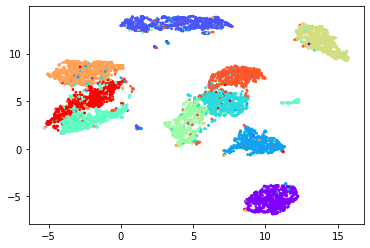

5 0.9292


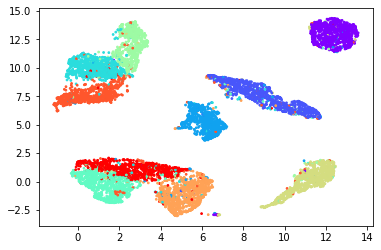

10 0.9437


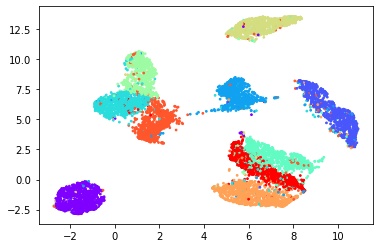

20 0.9266


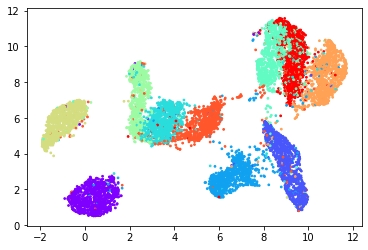

50 0.9061


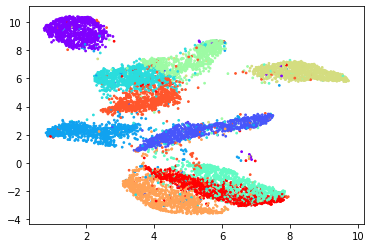

100 0.8909


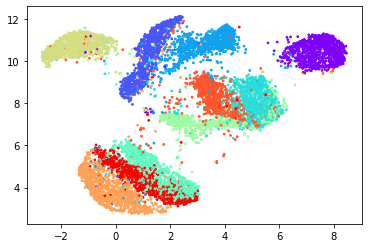

200 0.8625999999999999


In [210]:
all_embeds = []
i = 0

for n in [5, 10, 20, 50, 100, 200]:
    reducer = umap.UMAP(n_neighbors = n, min_dist = 0.1, init = 'random')        
    embedding = reducer.fit_transform(Xref)
    
    plt.scatter(x = embedding[:,0], y = embedding[:,1], c = colors, cmap = plt.cm.rainbow, s = 3)
    plt.show()
    
    all_embeds.append(embedding)
    
    print(n, calc_quality(embedding, colors))
    i +=1

In [37]:
all_embeds, m_rtd, m_cka  = pickle.load(open('mnist_umap.pickle', 'rb'))

In [38]:
from copy import copy

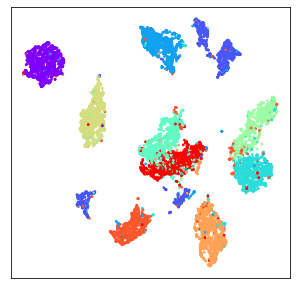

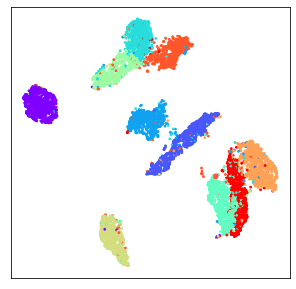

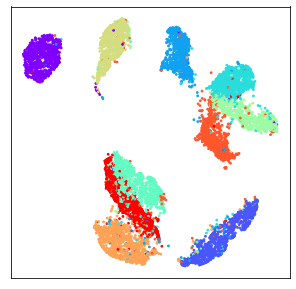

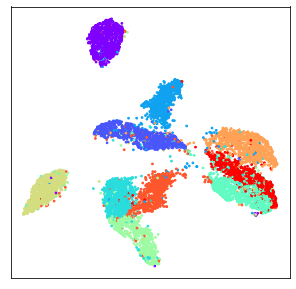

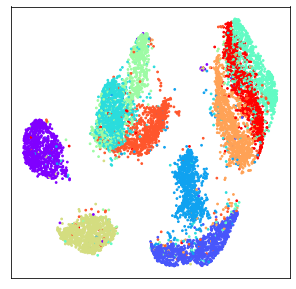

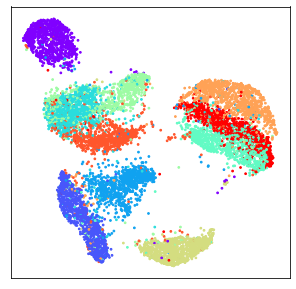

In [43]:
for idx, embedding in enumerate(all_embeds):
    
    # Create figure
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    
    embedding2 = copy(embedding)
    
    #
    # rotate embeddings to make them approx. aligned
    #
    if idx == 0:
        embedding2[:,0] = -embedding2[:,0]

    if idx == 3:
        embedding2[:,0] = -embedding2[:,0]
        embedding2[:,1] = -embedding2[:,1]
        
    if idx == 4:
        embedding2[:,1] = -embedding2[:,1]
        
    if idx == 5:
        embedding2[:,0] = -embedding2[:,0]
        
    plt.scatter(x = embedding2[:,0], y = embedding2[:,1], c = colors, cmap = plt.cm.rainbow, s = 3)
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

In [218]:
m_rtd2 = np.zeros((6, 6))
m_cka2 = np.zeros((6, 6))

for i in trange(len(all_embeds)):
    for j in range(len(all_embeds)):
        c = cka(all_embeds[i], all_embeds[j])
        if c > 0.999:
            c = 1.0
        
        m_cka[i, j] = 1 - c
        m_rtd[i ,j] = rtd_multi(all_embeds[i], all_embeds[j])

100%|██████████| 6/6 [28:24<00:00, 284.16s/it]


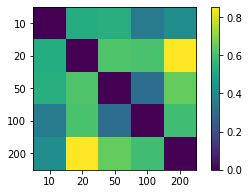

In [295]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from math import exp

# Create figure
fig = plt.figure(figsize=(8, 3))

ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(m_cka[1:,1:], cmap = 'viridis', interpolation = 'nearest')

ax.set_xticks(range(5))
ax.set_xticklabels([10, 20, 50, 100, 200])
ax.set_yticks(range(5))
ax.set_yticklabels([10, 20, 50, 100, 200])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.20)
plt.colorbar(im, cax=cax)

plt.show()

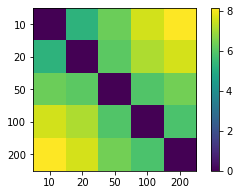

In [294]:
# Create figure
fig = plt.figure(figsize=(8, 3))

ax = fig.add_subplot(1, 1, 1)
im = ax.imshow((m_rtd[1:,1:] + m_rtd[1:,1:].T)/2, cmap = 'viridis', interpolation = 'nearest')

ax.set_xticks(range(5))
ax.set_xticklabels([10, 20, 50, 100, 200])
ax.set_yticks(range(5))
ax.set_yticklabels([10, 20, 50, 100, 200])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.20)
plt.colorbar(im, cax=cax)

plt.show()